# SECOM Tabular Model Training
===========================

XGBoost classifier for semiconductor yield prediction.

**Task**: Binary classification (Pass/Fail)
**Features**: 590 sensor features

## 1. Configuration

In [3]:
# Configuration - Adjust as needed
CONFIG = {
    'test_size': 0.2,
    'random_seed': 42,
    # XGBoost parameters
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'early_stopping_rounds': 20,
    # Calibration
    'use_calibration': True,
    'calibration_method': 'isotonic'  # or 'sigmoid'
}

## 2. Imports

In [4]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, f1_score
)
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 3. Load Data

In [5]:
# Paths
DATA_DIR = Path('../data/processed/secom')
MODEL_DIR = Path('../models/secom_xgboost')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Load data
X = pd.read_csv(DATA_DIR / 'secom_features.csv')
y = pd.read_csv(DATA_DIR / 'secom_labels.csv')['label'].values

print(f"Data shape: {X.shape}")
print(f"Class distribution: Pass={sum(y)}, Fail={len(y)-sum(y)}")
print(f"Pass rate: {y.mean()*100:.1f}%")

Data shape: (1567, 591)
Class distribution: Pass=125, Fail=1442
Pass rate: 8.0%


## 4. Preprocessing

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_seed'], 
    stratify=y
)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=CONFIG['random_seed'],
    stratify=y_train
)

print(f"Train: {len(X_tr)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1002, Val: 251, Test: 314


## 5. Train Model

In [7]:
# Calculate class weight
scale_pos_weight = (len(y_tr) - sum(y_tr)) / sum(y_tr)
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Create model
model = xgb.XGBClassifier(
    n_estimators=CONFIG['n_estimators'],
    max_depth=CONFIG['max_depth'],
    learning_rate=CONFIG['learning_rate'],
    scale_pos_weight=scale_pos_weight,
    random_state=CONFIG['random_seed'],
    eval_metric=['logloss', 'auc'],
    early_stopping_rounds=CONFIG['early_stopping_rounds'],
    verbosity=1
)

# Train
model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=50
)

print(f"\nBest iteration: {model.best_iteration}")

Scale pos weight: 11.53
[0]	validation_0-logloss:0.59853	validation_0-auc:1.00000
[20]	validation_0-logloss:0.06224	validation_0-auc:1.00000

Best iteration: 0


## 6. Evaluate Uncalibrated Model

In [8]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Metrics
metrics = {
    'auroc': roc_auc_score(y_test, y_prob),
    'prauc': average_precision_score(y_test, y_prob),
    'accuracy': (y_pred == y_test).mean(),
}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
metrics['tn'] = int(cm[0, 0])
metrics['fp'] = int(cm[0, 1])
metrics['fn'] = int(cm[1, 0])
metrics['tp'] = int(cm[1, 1])
metrics['precision'] = metrics['tp'] / (metrics['tp'] + metrics['fp']) if (metrics['tp'] + metrics['fp']) > 0 else 0
metrics['recall'] = metrics['tp'] / (metrics['tp'] + metrics['fn']) if (metrics['tp'] + metrics['fn']) > 0 else 0
metrics['f1'] = f1_score(y_test, y_pred)

print("Uncalibrated Model Metrics:")
print(f"  AUROC: {metrics['auroc']:.4f}")
print(f"  PR-AUC: {metrics['prauc']:.4f}")
print(f"  Accuracy: {metrics['accuracy']:.4f}")
print(f"  F1: {metrics['f1']:.4f}")

Uncalibrated Model Metrics:
  AUROC: 1.0000
  PR-AUC: 1.0000
  Accuracy: 1.0000
  F1: 1.0000


## 7. Calibrate Model (Optional)

In [7]:
if CONFIG['use_calibration']:
    print("Calibrating model...")
    calibrated_model = CalibratedClassifierCV(
        model, 
        method=CONFIG['calibration_method'], 
        cv=3
    )
    calibrated_model.fit(X_train_scaled, y_train)
    
    # Evaluate calibrated
    y_pred_cal = calibrated_model.predict(X_test_scaled)
    y_prob_cal = calibrated_model.predict_proba(X_test_scaled)[:, 1]
    
    cal_metrics = {
        'auroc': roc_auc_score(y_test, y_prob_cal),
        'prauc': average_precision_score(y_test, y_prob_cal),
        'accuracy': (y_pred_cal == y_test).mean(),
        'f1': f1_score(y_test, y_pred_cal)
    }
    
    print(f"\nCalibrated Model Metrics:")
    print(f"  AUROC: {cal_metrics['auroc']:.4f}")
    print(f"  PR-AUC: {cal_metrics['prauc']:.4f}")
    print(f"  Accuracy: {cal_metrics['accuracy']:.4f}")
    print(f"  F1: {cal_metrics['f1']:.4f}")
    
    # Use better model
    if cal_metrics['auroc'] > metrics['auroc']:
        final_model = calibrated_model
        final_metrics = cal_metrics
        final_prob = y_prob_cal
        print("\n→ Using calibrated model")
    else:
        final_model = model
        final_metrics = metrics
        final_prob = y_prob
        print("\n→ Using uncalibrated model")
else:
    final_model = model
    final_metrics = metrics
    final_prob = y_prob

Calibrating model...


ValueError: Must have at least 1 validation dataset for early stopping.

## 8. Visualization

NameError: name 'final_prob' is not defined

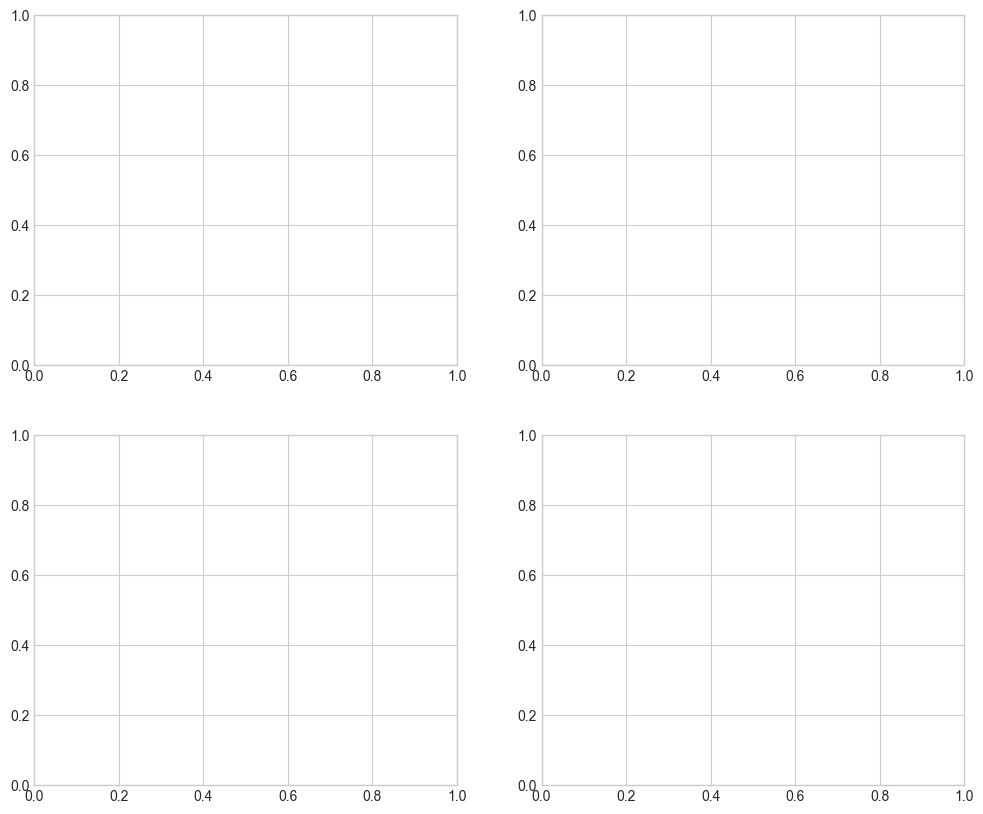

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_prob)
axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUROC={final_metrics["auroc"]:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_prob)
axes[0, 1].plot(recall, precision, 'r-', linewidth=2, label=f'PR (PRAUC={final_metrics["prauc"]:.3f})')
baseline = sum(y_test) / len(y_test)
axes[0, 1].axhline(baseline, color='k', linestyle='--', label=f'Baseline={baseline:.3f}')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_test, final_model.predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix')

# 4. Metrics Summary
metrics_text = f"""
Performance Metrics
====================
AUROC: {final_metrics['auroc']:.4f}
PR-AUC: {final_metrics['prauc']:.4f}
Accuracy: {final_metrics['accuracy']:.4f}
F1 Score: {final_metrics['f1']:.4f}
Precision: {final_metrics.get('precision', 0):.4f}
Recall: {final_metrics.get('recall', 0):.4f}
"""
axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')
axes[1, 1].set_title('Summary')

plt.tight_layout()
plt.savefig(MODEL_DIR / 'evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlots saved to {MODEL_DIR / 'evaluation_plots.png'}")

## 9. Save Model

In [ ]:
# Save model
with open(MODEL_DIR / "model.pkl", 'wb') as f:
    pickle.dump(final_model, f)

# Save preprocessors
with open(MODEL_DIR / "imputer.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(MODEL_DIR / "scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

# Save metrics
with open(MODEL_DIR / "metrics.json", 'w') as f:
    json.dump(final_metrics, f, indent=2)

print(f"Model saved to {MODEL_DIR}")

## 10. Feature Importance

In [ ]:
# Get feature importance
importance = model.feature_importances_
feature_names = X.columns

# Top 20 features
top_idx = np.argsort(importance)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(20), importance[top_idx], align='center')
plt.yticks(range(20), [feature_names[i] for i in top_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'feature_importance.png', dpi=150)
plt.show()

## Summary

Model trained and evaluated. Key metrics:
- AUROC: Measure of discrimination
- PR-AUC: Better for imbalanced data
- F1 Score: Balance of precision and recall

Next steps:
- Try hyperparameter tuning
- Add more sophisticated feature engineering
- Try ensemble methods